# Extraction of spectra
`author` Julien Morin <julien.morin@umontpellier.fr>

`date` 28 Jul 2022

Adapted from HAP703P

References: *Handbook of CCD Astronomy* §6 ; *Handbook of Astronomical Spectroscopy* §6
* compute master wavelength calibration file
* bias substract stellar frames (science and RV standard)
* extract stellar and calibration spectra
* save spectra as FITS files

In [1]:
# import and settings
%matplotlib notebook
import copy
import os
import matplotlib.pyplot as plt
import numpy as np
import scipy.ndimage
import astropy.io.fits as pf
from astropy.stats import mad_std
from astropy import units as u
from astropy.visualization import ZScaleInterval
import ccdproc as ccdp
import pydis_um 
import specutils
from iraf_um import imstat

## Load previously computed data 

In [2]:
# define CCD characteristics
ccd_gain = 0.9709756374359131 * u.electron / u.adu
ccd_ron = 2.8359016154485057 * u.electron

In [3]:
# load master bias and print stats
master_bias = ccdp.CCDData.read('reference/master_bias.fits', unit='adu')
imstat('master bias', master_bias)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
  frame id     npix     min      max    ...   mode     std      mad    unit
----------- --------- -------- -------- ... -------- -------- -------- ----
master bias    204800  298.094  303.156 ...  300.031    0.517    0.510  adu


In [4]:
# load master flat and print stats
master_flat = ccdp.CCDData.read('reference/master_flat.fits', unit='adu')
imstat('master flat', master_flat)

INFO: using the unit adu passed to the FITS reader instead of the unit adu in the FITS file. [astropy.nddata.ccddata]
  frame id     npix     min      max    ...   mode     std      mad    unit
----------- --------- -------- -------- ... -------- -------- -------- ----
master flat    204800    0.003    8.539 ...    0.005    2.112    1.382  adu


C:\Users\adria\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\adria\anaconda3\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


## Compute master ThAr

In [5]:
# create wavelength calibration frame collection and print properties
ifc_cal = ccdp.ImageFileCollection('calibration/', glob_include='ThAr_*.fit*')
print(ifc_cal.summary['date', 'exposure'])
# load ThAr CCDData objects and reshape data to be 2-D images
# using an ImageFileCollection does not work because of the data shape (naxis=3)
print()
ccdd_cal = [ccdp.CCDData.read(ifc_cal.location+cal_file, unit='adu') for cal_file in ifc_cal.files]
print("original ThAr shape:", ccdd_cal[0].data.shape)
for c in ccdd_cal:
    c.data = c.data[0]
print("new ThAr shape:", ccdd_cal[0].data.shape)
print("")

# exclude the ThAr w/ differents stats
imstat(ifc_cal.files, ccdd_cal)
ccdd_cal = ccdd_cal[1:]
fname_cal = ifc_cal.files[1:]
#imstat(fname_cal, ccdd_cal)

        date        exposure
------------------- --------
2022-09-21T18:28:07     15.0
2022-09-21T18:28:53     15.0
2022-09-21T18:29:14     15.0
2022-09-21T18:29:35     15.0
2022-09-21T18:30:32     15.0

original ThAr shape: (1, 100, 2048)
new ThAr shape: (100, 2048)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
ThAr_M2_ML_Wed Sep 21 2022_18.28.27_00000.fits    204800 ...  123.056  adu
ThAr_M2_ML_Wed Sep 21 2022_18.29.12_00001.fits    204800 ...  126.021  adu
ThAr_M2_ML_Wed Sep 21 2022_18.29.34_00002.fits    204800 ...  127.504  adu
ThAr_M2_ML_Wed Sep 21 2022_18.29.55_00003.fits    204800 ...  128.986  adu
ThAr_M2_ML_Wed Sep 21 2022_18.30.52_00004.fits    204800 ...  130.469  adu


In [6]:
# compute master calibration 
master_cal = ccdp.combine(ccdd_cal, unit='adu', combine='average', 
    sigma_clip=True, sigma_clip_low_thresh=7., sigma_clip_high_thresh=7., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
    mem_limit=512.e6)

In [7]:
# set header keyword (will appear in the saved file)
master_cal.meta['COMBINED'] = True

In [8]:
# compare statiscal properties of the series and the master frame
imstat(fname_cal, ccdd_cal)
print('\n')
imstat('master cal', master_cal)

                   frame id                       npix   ...   mad    unit
---------------------------------------------- --------- ... -------- ----
ThAr_M2_ML_Wed Sep 21 2022_18.29.12_00001.fits    204800 ...  126.021  adu
ThAr_M2_ML_Wed Sep 21 2022_18.29.34_00002.fits    204800 ...  127.504  adu
ThAr_M2_ML_Wed Sep 21 2022_18.29.55_00003.fits    204800 ...  128.986  adu
ThAr_M2_ML_Wed Sep 21 2022_18.30.52_00004.fits    204800 ...  130.469  adu


 frame id     npix     min       max    ...   mode     std      mad    unit
---------- --------- -------- --------- ... -------- -------- -------- ----
master cal    204800  299.000 24085.250 ...  312.000 1208.491  128.245  adu


C:\Users\adria\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\adria\anaconda3\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


In [9]:
# bias subtract the master cal and print statistics
master_cal_b = ccdp.subtract_bias(master_cal, master_bias)
imstat('mcal b', master_cal_b)

frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
  mcal b    204800   -1.812 23784.969 ...   27.031 1208.493  128.245  adu


C:\Users\adria\anaconda3\lib\site-packages\numpy\core\fromnumeric.py:748: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
C:\Users\adria\anaconda3\lib\site-packages\numpy\lib\function_base.py:3550: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


<IPython.core.display.Javascript object>


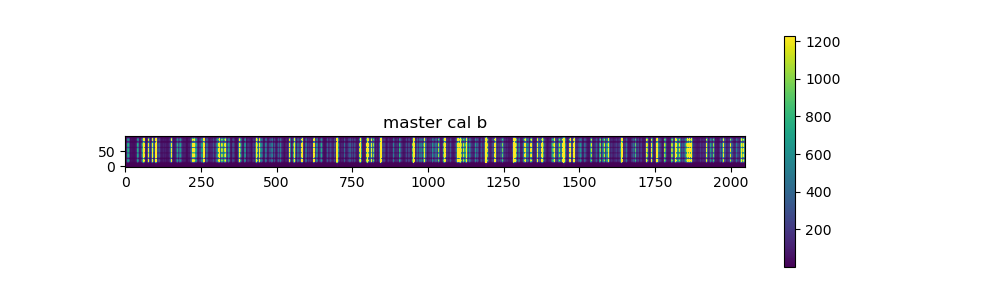

In [10]:
%matplotlib notebook
# display master cal
fig = plt.figure(figsize=(10,3))
#
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(master_cal_b)
im = plt.imshow(master_cal_b.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im)
plt.gca().set_title('master cal b')

plt.show()

## Calibrate science  and rv standard frames

In [11]:
#Reshaping Target
ifc_M76 = ccdp.ImageFileCollection('raw/', glob_include='M76_*.fit*')
M76_recalibrated = [ccdp.CCDData.read(ifc_M76.location+M76_file, unit='adu') for M76_file in ifc_M76.files]
print("original SR shape:", M76_recalibrated[0].data.shape)
for b in M76_recalibrated:
    b.data = b.data[0]
print("new SR shape:", M76_recalibrated[0].data.shape)
print("")

        date        exposure
------------------- --------
2022-09-22T00:03:11   1200.0
2022-09-22T00:23:59   1200.0
2022-09-22T00:45:17   1200.0
2022-09-22T01:05:55   1200.0
2022-09-22T01:31:30   1200.0
2022-09-22T01:54:29   1200.0
2022-09-22T02:20:40   1200.0
2022-09-22T02:41:27   1200.0
2022-09-22T03:02:05   1200.0
2022-09-22T03:24:36   1200.0
2022-09-22T03:45:48   1200.0
2022-09-21T23:39:09   1200.0
original SR shape: (1, 100, 2048)
new SR shape: (100, 2048)



In [12]:
#Combine Target
fname_sci = 'Master_M76.fit'
ccd_sci = ccdp.combine(M76_recalibrated, unit='adu', combine='sum', 
    sigma_clip=True, sigma_clip_low_thresh=7., sigma_clip_high_thresh=7., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
    mem_limit=512.e6)

In [13]:
#Reshaping Star reference
ifc_ksi_Cas = ccdp.ImageFileCollection('ksi_Cas/', glob_include='Ksi_Cas_*.fit*')
ksi_Cas_recalibrated = [ccdp.CCDData.read(ifc_ksi_Cas.location+ksi_Cas_file, unit='adu') for ksi_Cas_file in ifc_ksi_Cas.files]
print("original SR shape:", ksi_Cas_recalibrated[0].data.shape)
for b in ksi_Cas_recalibrated:
    b.data = b.data[0]
print("new SR shape:", ksi_Cas_recalibrated[0].data.shape)
print("")

original SR shape: (1, 100, 2048)
new SR shape: (100, 2048)



In [14]:
#Combine Star reference images
fname_rvstd = 'Master_ksi_Cas.fit'
ccd_rvstd = ccdp.combine(ksi_Cas_recalibrated, unit='adu', combine='sum', 
    sigma_clip=True, sigma_clip_low_thresh=7., sigma_clip_high_thresh=7., sigma_clip_func=np.ma.median, sigma_clip_dev_func=mad_std,
    mem_limit=512.e6)

In [15]:
# target: ER Vul
#fname_sci = 'ER_Vul_AMT_01.30.27_00024.fits'
#ccd_sci = ccdp.CCDData.read('raw/'+fname_sci, unit='adu')
#print("original sci shape:", ccd_sci.data.shape)
#ccd_sci.data = ccd_sci.data[0]
#print("new sci shape:", ccd_sci.data.shape)
#print("")

# radial velocity standard: 
#fname_rvstd = 'HD196850_AMT_02.10.13_00004.fits'
#ccd_rvstd = ccdp.CCDData.read('raw/'+fname_rvstd, unit='adu')
#print("original rvstd shape:", ccd_rvstd.data.shape)
#ccd_rvstd.data = ccd_rvstd.data[0]
#print("new rvstd shape:", ccd_rvstd.data.shape)
#print("")


In [16]:
# bias subtract the master cal and print statistics
ccd_sci_b = ccdp.subtract_bias(ccd_sci, master_bias)
imstat(['sci', 'sci b'], [ccd_sci, ccd_sci_b])

print()

# same for rv std
ccd_rvstd_b = ccdp.subtract_bias(ccd_rvstd, master_bias)
imstat(['rvstd', 'rvstd b'], [ccd_rvstd, ccd_rvstd_b])

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


frame id    npix     min      max    ...   mode     std      mad    unit
-------- --------- -------- -------- ... -------- -------- -------- ----
     sci    204800  298.300 1048.583 ...  302.833   18.836    0.988  adu
   sci b    204800   -3.042  748.677 ...    0.354   18.843    1.127  adu



/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


frame id    npix     min       max    ...   mode     std      mad    unit
-------- --------- -------- --------- ... -------- -------- -------- ----
   rvstd    204800  320.333 17551.000 ...  338.200 3826.480 3387.746  adu
 rvstd b    204800   19.271 17250.562 ...   32.900 3826.486 3387.982  adu


<IPython.core.display.Javascript object>


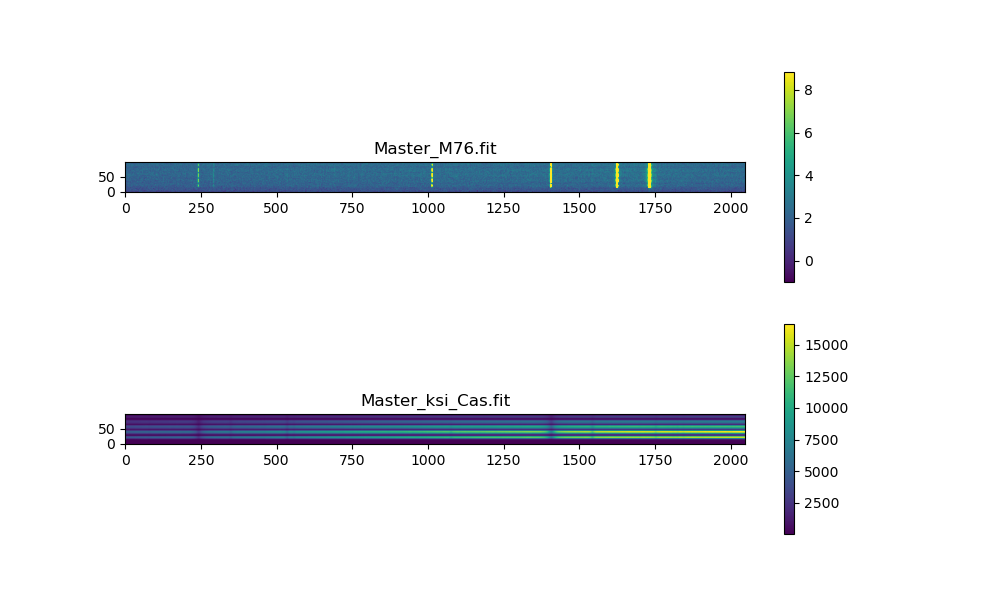

In [17]:
%matplotlib notebook
# display bias-subtracted sci and rv std frames
fig = plt.figure(figsize=(10,6))
#
ax1 = fig.add_subplot(211)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccd_sci_b)
im1 = ax1.imshow(ccd_sci_b.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im1)
plt.gca().set_title(fname_sci)
#
ax2 = fig.add_subplot(212)
interval1 = ZScaleInterval()
z1, z2 = interval1.get_limits(ccd_rvstd_b)
im2 = ax2.imshow(ccd_rvstd_b.data, origin='lower', vmin=z1, vmax=z2)
fig.colorbar(im2)
plt.gca().set_title(fname_rvstd)

plt.show()

In [18]:
ccd_sci_b = ccdp.gain_correct(ccd_sci_b,ccd_gain)
imstat('M76' + '_b', ccd_sci_b)

#print()

ccd_rvstd_b = ccdp.gain_correct(ccd_rvstd_b, ccd_gain)
imstat('ksi_Cas' + '_b', ccd_rvstd_b)

/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


frame id    npix     min      max    ...   mode     std      mad      unit  
-------- --------- -------- -------- ... -------- -------- -------- --------
   M76_b    204800   -2.953  726.947 ...    0.344   18.296    1.095 electron


/usr/local/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:753: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/usr/local/anaconda3/lib/python3.8/site-packages/numpy/lib/function_base.py:3636: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  part.partition(kth)


 frame id    npix     min       max    ...   mode     std      mad      unit  
--------- --------- -------- --------- ... -------- -------- -------- --------
ksi_Cas_b    204800   18.712 16749.876 ...   31.945 3715.425 3289.648 electron


## Define spectral trace

<IPython.core.display.Javascript object>


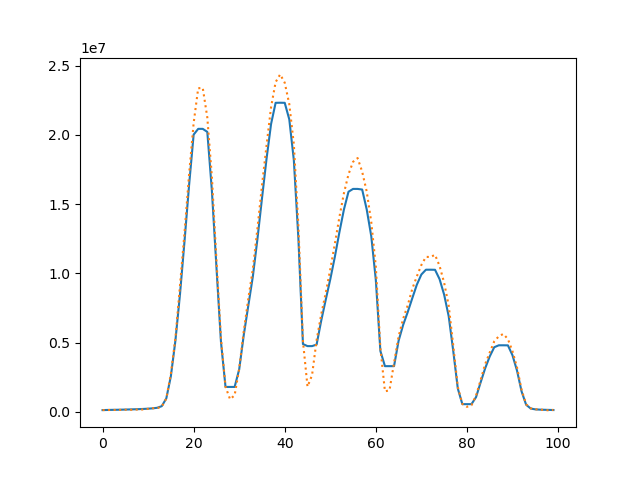

In [19]:
# plot sum of columns and rescaled central column
img_sm = scipy.signal.medfilt2d(ccd_rvstd_b, kernel_size=(5,5))
ztot = img_sm.sum(axis=1)
plt.figure()
plt.plot(ztot)
plt.plot(ccd_rvstd_b.data[:,1024]*2048, ls=':')
plt.show()

In [20]:
# define spectrum limits to isolate individual apertures
## aperture #2
#ap_center = [41]
#ap_min = [29]
#ap_max = [46]
## aperture #3 (central)
ap_center = [60]
ap_min = [46]
ap_max = [66]

In [21]:
# define trace on science spectrum
#trace = pydis.ap_trace(ccd_sci_b.data, nsteps=8, bigbox=7, interac=False, display=True)
# use custom ap_trace function

#######################     MODIF     #######################################
#Init :
#trace = pydis_um.ap_trace(ccd_rvstd_b.data, nsteps=16, bigbox=7, ap_center=ap_center, ap_min=ap_min, ap_max=ap_max, display=True)
#Already commmented
#trace = pydis.ap_trace(ccd_sci_b.data, nsteps=8, bigbox=7, display=True)

trace=np.zeros(2048)+57

print(trace.shape)
print(trace)

(2048,)
[57. 57. 57. ... 57. 57. 57.]


<IPython.core.display.Javascript object>


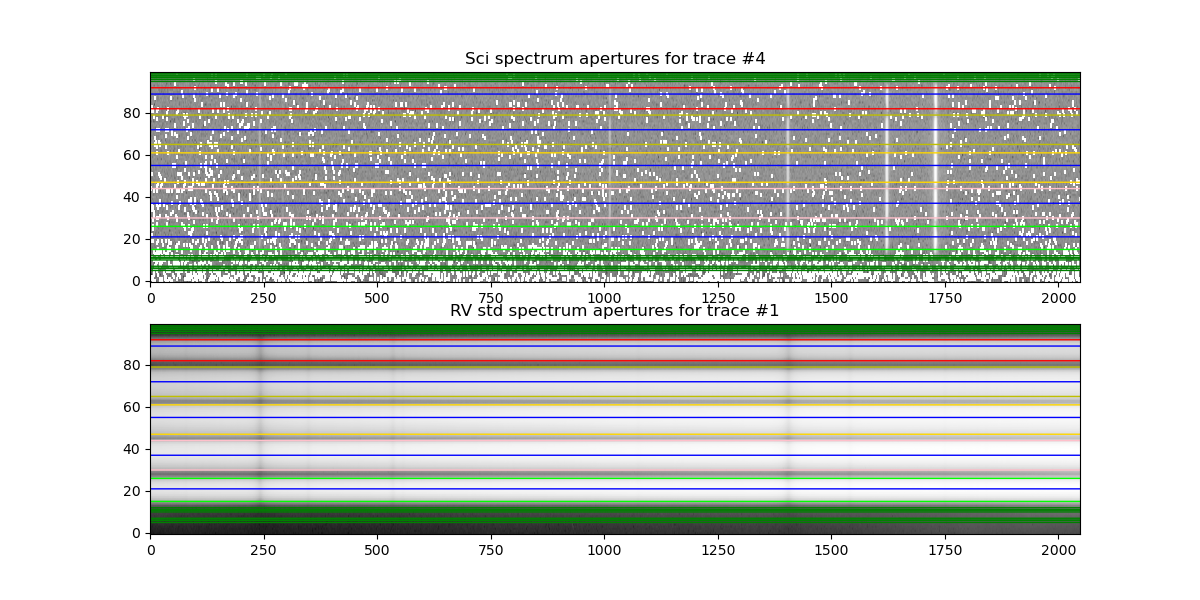

<ipython-input-22-2c39d9fc293e>:31: RuntimeWarning: divide by zero encountered in log10
  ax1.imshow(np.log10(ccd_sci_b.data), origin='lower',aspect='auto',cmap='Greys_r')
<ipython-input-22-2c39d9fc293e>:31: RuntimeWarning: invalid value encountered in log10
  ax1.imshow(np.log10(ccd_sci_b.data), origin='lower',aspect='auto',cmap='Greys_r')
/skole/nas-edu/home0/ccp2/darricau-a/Bureau/OHP/V8 Adrian/21-09-22/pydis_um.py:411: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +


low : [82. 82. 82. ... 82. 82. 82.] up :  [92. 92. 92. ... 92. 92. 92.] color : r


/skole/nas-edu/home0/ccp2/darricau-a/Bureau/OHP/V8 Adrian/21-09-22/pydis_um.py:411: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +


low : [65. 65. 65. ... 65. 65. 65.] up :  [79. 79. 79. ... 79. 79. 79.] color : y


/skole/nas-edu/home0/ccp2/darricau-a/Bureau/OHP/V8 Adrian/21-09-22/pydis_um.py:411: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +


low : [47. 47. 47. ... 47. 47. 47.] up :  [61. 61. 61. ... 61. 61. 61.] color : gold


/skole/nas-edu/home0/ccp2/darricau-a/Bureau/OHP/V8 Adrian/21-09-22/pydis_um.py:411: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +


low : [30. 30. 30. ... 30. 30. 30.] up :  [44. 44. 44. ... 44. 44. 44.] color : pink


/skole/nas-edu/home0/ccp2/darricau-a/Bureau/OHP/V8 Adrian/21-09-22/pydis_um.py:411: RuntimeWarning: invalid value encountered in sqrt
  fluxerr[i] = np.sqrt(np.sum((onedspec[i]-skysubflux[i])/coaddN) +


low : [15. 15. 15. ... 15. 15. 15.] up :  [26. 26. 26. ... 26. 26. 26.] color : lime


In [22]:
#######################     MODIF     #######################################
#Ceci est la combinaison des 5 spectres

Ap_l=[7,7,8,7,6]
Ap_u=[3,7,6,7,5]
Trace=[np.zeros(2048)+89,np.zeros(2048)+72,np.zeros(2048)+55,np.zeros(2048)+37,np.zeros(2048)+21]

Skysep_u = [97-89-5,97-72-7,97-55-7,97-37-8,97-21-5]
Skysep_l = [89-12-5,72-12-7,55-12-7,37-12-6,21-12-5]

Sky_l = [5,5,5,5,5]
Sky_u = [2,2,2,2,2]

SCI_SPEC,SCI_SKY,SCI_ERR=0,0,0



apwidth = 32
skysep = 2
skywidth = 4



xbins = np.arange(ccd_sci_b.data.shape[1])

fig = plt.figure(figsize=(12,6))
# plot apertures on science spectrum
ax1 = fig.add_subplot(211)
#interval1 = ZScaleInterval()
#z1, z2 = interval1.get_limits(ccd_sci[250:550,:])
ax1.imshow(np.log10(ccd_sci_b.data), origin='lower',aspect='auto',cmap='Greys_r')
# the trace
j=0
c=['r','y','gold','pink','lime']

ax2 = fig.add_subplot(212)
interval1 = ZScaleInterval()
#z1, z2 = interval1.get_limits(ccd_sci[250:550,:])
ax2.imshow(np.log10(ccd_rvstd_b.data), origin='lower',aspect='auto',cmap='Greys_r')

for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    sci_spec, sci_sky, sci_err = pydis_um.ap_extract(ccd_sci_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
    SCI_SPEC+=sci_spec
    SCI_SKY+=sci_sky
    SCI_ERR += sci_err**2
# extract rv standard spectrum on the defined trace
    rvstd_spec, rvstd_sky, rvstd_err = pydis_um.ap_extract(ccd_rvstd_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
# extract calibration spectrum with the same trace
    cal_spec, cal_sky, cal_err = pydis_um.ap_extract(master_cal_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
# extract flat field spectrum with the same trace
    flat_spec, flat_sky, flat_err = pydis_um.ap_extract(master_flat.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
# plot
    ax1.plot(xbins, trace,'b',lw=1)
# the aperture
    ax1.plot(xbins, trace-ap_l,c[j],lw=1)
    ax1.plot(xbins, trace+ap_u,c[j],lw=1)
# the sky regions
    ax1.plot(xbins, trace-ap_l-skysep_l,'g',lw=1)
    ax1.plot(xbins, trace-ap_l-skysep_l-sky_l,'g',lw=1)
    ax1.plot(xbins, trace+ap_u+skysep_u,'g',lw=1)
    ax1.plot(xbins, trace+ap_u+skysep_u+sky_u,'g',lw=1)
#
    ax1.set_title('Sci spectrum apertures for trace #'+str(j))
    
    ax2.plot(xbins, trace,'b',lw=1)
# the aperture
    print("low :",trace-ap_l,"up : ",trace+ap_u,"color :",c[j])
    ax2.plot(xbins, trace-ap_l,c[j],lw=1)
    ax2.plot(xbins, trace+ap_u,c[j],lw=1)
        
# the sky regions
    ax2.plot(xbins, trace-ap_l-skysep_l,'g',lw=1)
    ax2.plot(xbins, trace-ap_l-skysep_l-sky_l,'g',lw=1)
    ax2.plot(xbins, trace+ap_u+skysep_u,'g',lw=1)
    ax2.plot(xbins, trace+ap_u+skysep_u+sky_u,'g',lw=1)
# 
    j+=1
ax2.set_title('RV std spectrum apertures for trace #1')
plt.show()

# Je remet les noms de bases pour pas me faire chier a changer toutes les noms de variables
sci_spec=SCI_SPEC
sci_sky=SCI_SKY
sci_err=np.sqrt(SCI_ERR)

In [23]:
"""
# extract science spectrum on the defined trace
## full spectrum
#ap_l = 38
#ap_u = 34
#skysep_l = 8
#skysep_u = 4
#sky_l = 4
#sky_u = 0
## central aperture

#############     Modif    ############### 
#Notes : Soit sommes des 5 bandes soit prendre tout + essayer ligne pour trace
#Init :

ap_l = 43
ap_u = 36
skysep_l = 3
skysep_u = 3
sky_l = 2
sky_u = 2
sci_spec, sci_sky, sci_err = pydis_um.ap_extract(ccd_sci_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
############  END BACKUP   ###############


Ap_l=[5,7,7,6,5]
Ap_u=[5,7,7,8,5]
Trace=[np.zeros(2048)+89,np.zeros(2048)+72,np.zeros(2048)+55,np.zeros(2048)+37,np.zeros(2048)+21]

Skysep_l = [2,3,3,3,3]
Skysep_u = [3,3,3,3,3]

Sky_l = [1,2,2,2,2]
Sky_u = [2,2,2,2,2]

SCI_SPEC,SCI_SKY,SCI_ERR=0,0,0
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    sci_spec, sci_sky, sci_err = pydis_um.ap_extract(ccd_sci_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
    SCI_SPEC+=sci_spec
    SCI_SKY+=sci_sky
    SCI_ERR+=sci_err

# extract rv standard spectrum on the defined trace
apwidth = 32
skysep = 2
skywidth = 4
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    rvstd_spec, rvstd_sky, rvstd_err = pydis_um.ap_extract(ccd_rvstd_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
    """

'\n# extract science spectrum on the defined trace\n## full spectrum\n#ap_l = 38\n#ap_u = 34\n#skysep_l = 8\n#skysep_u = 4\n#sky_l = 4\n#sky_u = 0\n## central aperture\n\n#############     Modif    ############### \n#Notes : Soit sommes des 5 bandes soit prendre tout + essayer ligne pour trace\n#Init :\n\nap_l = 43\nap_u = 36\nskysep_l = 3\nskysep_u = 3\nsky_l = 2\nsky_u = 2\nsci_spec, sci_sky, sci_err = pydis_um.ap_extract(ccd_sci_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)\n############  END BACKUP   ###############\n\n\nAp_l=[5,7,7,6,5]\nAp_u=[5,7,7,8,5]\nTrace=[np.zeros(2048)+89,np.zeros(2048)+72,np.zeros(2048)+55,np.zeros(2048)+37,np.zeros(2048)+21]\n\nSkysep_l = [2,3,3,3,3]\nSkysep_u = [3,3,3,3,3]\n\nSky_l = [1,2,2,2,2]\nSky_u = [2,2,2,2,2]\n\nSCI_SPEC,SCI_SKY,SCI_ERR=0,0,0\nfor ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):\n    #print("ap_l = ",ap_l

In [24]:
"""
# extract calibration spectrum with the same trace
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    cal_spec, cal_sky, cal_err = pydis_um.ap_extract(master_cal_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
    """

'\n# extract calibration spectrum with the same trace\nfor ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):\n    #print("ap_l = ",ap_l," ap_u = ",ap_u)\n    cal_spec, cal_sky, cal_err = pydis_um.ap_extract(master_cal_b.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)\n    '

In [25]:
"""# extract flat field spectrum with the same trace
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    flat_spec, flat_sky, flat_err = pydis_um.ap_extract(master_flat.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)
    """

'# extract flat field spectrum with the same trace\nfor ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):\n    #print("ap_l = ",ap_l," ap_u = ",ap_u)\n    flat_spec, flat_sky, flat_err = pydis_um.ap_extract(master_flat.data, trace, ap_l=ap_l, ap_u=ap_u, skysep_l=skysep_l, skysep_u=skysep_u, sky_l=sky_l, sky_u=sky_u, skydeg=0, coaddN=1)\n    '

In [26]:
"""
xbins = np.arange(ccd_sci_b.data.shape[1])

fig = plt.figure(figsize=(12,6))
# plot apertures on science spectrum
ax1 = fig.add_subplot(211)
#interval1 = ZScaleInterval()
#z1, z2 = interval1.get_limits(ccd_sci[250:550,:])
ax1.imshow(np.log10(ccd_sci_b.data), origin='lower',aspect='auto',cmap='Greys_r')
# the trace
j=0
c=['r','y','gold','pink','lime']
for ap_l,ap_u,trace in zip(Ap_l,Ap_u,Trace):
    ax1.plot(xbins, trace,'b',lw=1)
# the aperture
    ax1.plot(xbins, trace-ap_l,c[j],lw=1)
    ax1.plot(xbins, trace+ap_u,c[j],lw=1)
# the sky regions
j=0
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    j+=1
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
    ax1.plot(xbins, trace-ap_l-skysep_l,'g',lw=1)
    ax1.plot(xbins, trace-ap_l-skysep_l-sky_l,'g',lw=1)
    ax1.plot(xbins, trace+ap_u+skysep_u,'g',lw=1)
    ax1.plot(xbins, trace+ap_u+skysep_u+sky_u,'g',lw=1)
#
    ax1.set_title('Sci spectrum apertures for trace #'+str(j))
#
ax2 = fig.add_subplot(212)
interval1 = ZScaleInterval()
#z1, z2 = interval1.get_limits(ccd_sci[250:550,:])
ax2.imshow(np.log10(ccd_rvstd_b.data), origin='lower',aspect='auto',cmap='Greys_r')
# the trace
j=0
for ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):
    if j==0:
        ax2.plot(xbins, trace,'b',lw=1)
# the aperture
    
    #print("ap_l = ",ap_l," ap_u = ",ap_u)
        print("low :",trace-ap_l,"up : ",trace+ap_u,"color :",c[j])
        ax2.plot(xbins, trace-ap_l,c[j],lw=1)
        ax2.plot(xbins, trace+ap_u,c[j],lw=1)
        j+=1
# the sky regions
    
        ax2.plot(xbins, trace-ap_l-skysep_l,'g',lw=1)
        ax2.plot(xbins, trace-ap_l-skysep_l-sky_l,'g',lw=1)
        ax2.plot(xbins, trace+ap_u+skysep_u,'g',lw=1)
        ax2.plot(xbins, trace+ap_u+skysep_u+sky_u,'g',lw=1)
#
ax2.set_title('RV std spectrum apertures for trace #1')


    
#


plt.show()
"""

'\nxbins = np.arange(ccd_sci_b.data.shape[1])\n\nfig = plt.figure(figsize=(12,6))\n# plot apertures on science spectrum\nax1 = fig.add_subplot(211)\n#interval1 = ZScaleInterval()\n#z1, z2 = interval1.get_limits(ccd_sci[250:550,:])\nax1.imshow(np.log10(ccd_sci_b.data), origin=\'lower\',aspect=\'auto\',cmap=\'Greys_r\')\n# the trace\nj=0\nc=[\'r\',\'y\',\'gold\',\'pink\',\'lime\']\nfor ap_l,ap_u,trace in zip(Ap_l,Ap_u,Trace):\n    ax1.plot(xbins, trace,\'b\',lw=1)\n# the aperture\n    ax1.plot(xbins, trace-ap_l,c[j],lw=1)\n    ax1.plot(xbins, trace+ap_u,c[j],lw=1)\n# the sky regions\nj=0\nfor ap_l,ap_u,trace,skysep_l,skysep_u,sky_l,sky_u in zip(Ap_l,Ap_u,Trace,Skysep_l,Skysep_u,Sky_l,Sky_u):\n    j+=1\n    #print("ap_l = ",ap_l," ap_u = ",ap_u)\n    ax1.plot(xbins, trace-ap_l-skysep_l,\'g\',lw=1)\n    ax1.plot(xbins, trace-ap_l-skysep_l-sky_l,\'g\',lw=1)\n    ax1.plot(xbins, trace+ap_u+skysep_u,\'g\',lw=1)\n    ax1.plot(xbins, trace+ap_u+skysep_u+sky_u,\'g\',lw=1)\n#\n    ax1.set_title(\

<IPython.core.display.Javascript object>


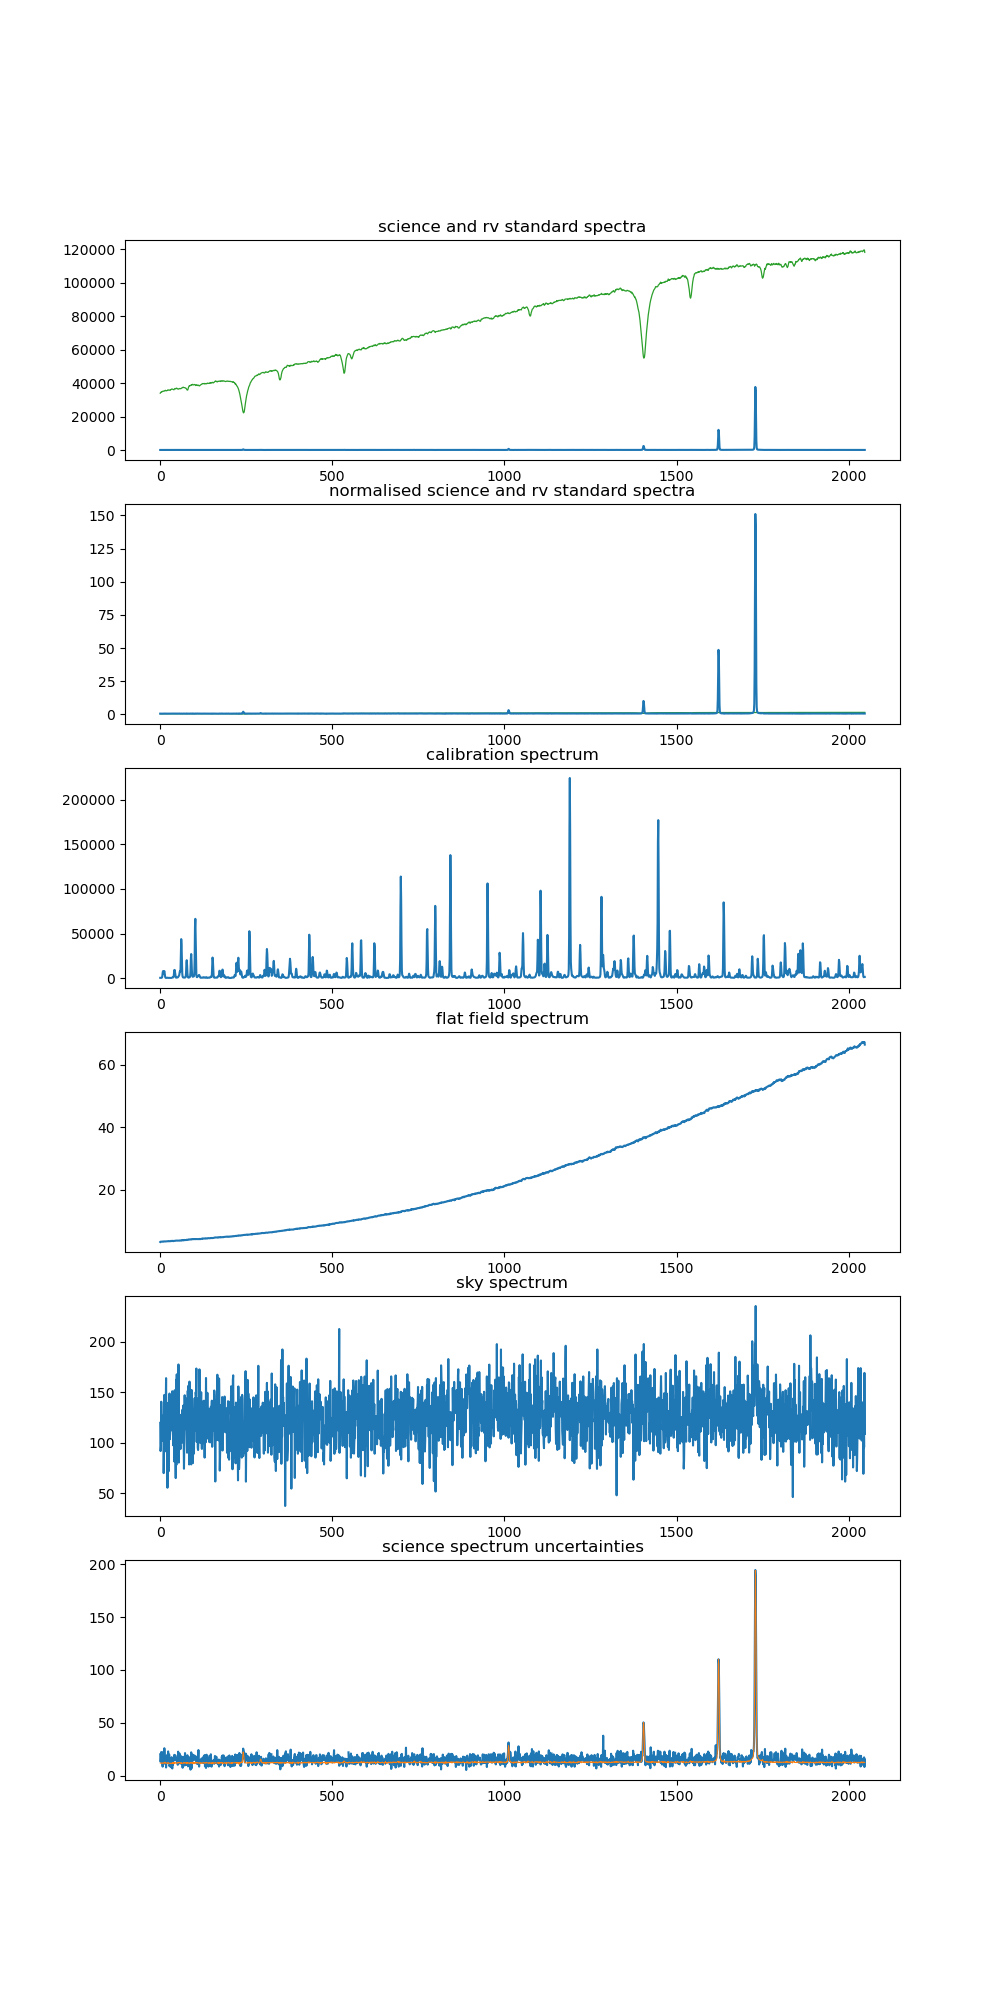

In [27]:
#### AVEC SOMME ####
fig = plt.figure(figsize=(10,20))
#
ax1 = fig.add_subplot(611)
ax1.plot(rvstd_spec, c='tab:green', lw=.9)
ax1.plot(sci_spec)
ax1.set_title('science and rv standard spectra')
#
ax2 = fig.add_subplot(612)
ax2.plot(rvstd_spec/np.mean(rvstd_spec), c='tab:green', lw=.9)
ax2.plot(sci_spec/np.mean(sci_spec))
ax2.set_title('normalised science and rv standard spectra')

#
ax2 = fig.add_subplot(613)
ax2.plot(cal_spec)
ax2.set_title('calibration spectrum')
#
ax3 = fig.add_subplot(614)
ax3.plot(flat_spec)
ax3.set_title('flat field spectrum')
#
ax4 = fig.add_subplot(615)
ax4.plot(sci_sky)
ax4.set_title('sky spectrum')
#
ax5 = fig.add_subplot(616)
ax5.plot(sci_err)
ax5.plot(np.sqrt(sci_spec), lw=0.7)
ax5.set_title('science spectrum uncertainties')
#
plt.show()

In [28]:
"""
### SANS SOMME ###
fig = plt.figure(figsize=(10,20))
#
ax1 = fig.add_subplot(611)
ax1.plot(rvstd_spec, c='tab:green', lw=.9)
ax1.plot(sci_spec)
ax1.set_title('science and rv standard spectra')
#
ax2 = fig.add_subplot(612)
ax2.plot(rvstd_spec/np.mean(rvstd_spec), c='tab:green', lw=.9)
ax2.plot(sci_spec/np.mean(sci_spec))
ax2.set_title('normalised science and rv standard spectra')

#
ax2 = fig.add_subplot(613)
ax2.plot(cal_spec)
ax2.set_title('calibration spectrum')
#
ax3 = fig.add_subplot(614)
ax3.plot(flat_spec)
ax3.set_title('flat field spectrum')
#
ax4 = fig.add_subplot(615)
ax4.plot(sci_sky)
ax4.set_title('sky spectrum')
#
ax5 = fig.add_subplot(616)
ax5.plot(sci_err)
ax5.plot(np.sqrt(sci_spec), lw=0.7)
#ax5.plot(np.sqrt(sci_spec), lw=0.7)
ax5.set_title('science spectrum uncertainties')
#
plt.show()

"""

"\n### SANS SOMME ###\nfig = plt.figure(figsize=(10,20))\n#\nax1 = fig.add_subplot(611)\nax1.plot(rvstd_spec, c='tab:green', lw=.9)\nax1.plot(sci_spec)\nax1.set_title('science and rv standard spectra')\n#\nax2 = fig.add_subplot(612)\nax2.plot(rvstd_spec/np.mean(rvstd_spec), c='tab:green', lw=.9)\nax2.plot(sci_spec/np.mean(sci_spec))\nax2.set_title('normalised science and rv standard spectra')\n\n#\nax2 = fig.add_subplot(613)\nax2.plot(cal_spec)\nax2.set_title('calibration spectrum')\n#\nax3 = fig.add_subplot(614)\nax3.plot(flat_spec)\nax3.set_title('flat field spectrum')\n#\nax4 = fig.add_subplot(615)\nax4.plot(sci_sky)\nax4.set_title('sky spectrum')\n#\nax5 = fig.add_subplot(616)\nax5.plot(sci_err)\nax5.plot(np.sqrt(sci_spec), lw=0.7)\n#ax5.plot(np.sqrt(sci_spec), lw=0.7)\nax5.set_title('science spectrum uncertainties')\n#\nplt.show()\n\n"

## Save spectra

In [29]:
# science spectrum
s1d_sci = ccdp.CCDData(data=sci_spec, meta=ccd_sci.meta, mask=None, uncertainty=sci_err, unit='electron')
fname_s1d_sci = os.path.splitext(fname_sci)[0] + '_s1d' + os.path.splitext(fname_sci)[1]
s1d_sci.write('reduced/'+fname_s1d_sci, overwrite=True)
# rv std
s1d_rvstd = ccdp.CCDData(data=rvstd_spec, meta=ccd_rvstd.meta, mask=None, uncertainty=rvstd_err, unit='electron')
fname_s1d_rvstd = os.path.splitext(fname_rvstd)[0] + '_s1d' + os.path.splitext(fname_rvstd)[1]
s1d_rvstd.write('reduced/'+fname_s1d_rvstd, overwrite=True)

INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


INFO:astropy:array provided for uncertainty; assuming it is a StdDevUncertainty.


INFO: array provided for uncertainty; assuming it is a StdDevUncertainty. [astropy.nddata.ccddata]


INFO:astropy:array provided for uncertainty; assuming it is a StdDevUncertainty.


In [30]:
# flat field spectrum
s1d_flat = ccdp.CCDData(data=flat_spec, meta=master_flat.meta, mask=None, uncertainty=None, unit='adu')
s1d_flat.write('reference/master_flat_s1d.fits', overwrite=True)

In [31]:
# wavelength calibration spectrum
s1d_cal = ccdp.CCDData(data=cal_spec, meta=master_cal.meta, mask=None, uncertainty=None, unit='adu')
s1d_cal.write('reference/master_wcal_s1d.fits', overwrite=True)

## Remark: do not define spectral trace on an emission spectrum